# Setup

In [3]:
import numpy as np  
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
import discr 
import scipy.stats as ss

# Example

Convergence with 4 moments!


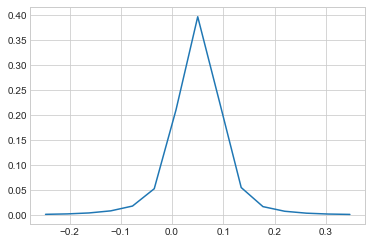

In [4]:
Nm = 15 # Number of points in grid 
nMoments = 4 # Number of moments to (try to) match 
rho = 0.5 # persistence of AR(1) process
if rho <= 1-2/(Nm-1):
    nSigmas = np.sqrt(2*(Nm-1));
else:
    nSigmas = np.sqrt(Nm-1);

mu = 0.05 # unconditonal mean 
sigmaC = np.array([0.1, 0.03]) # std. of normal dists.
muC = np.array([-0.004, 0.001]) # mean og normal dists. 
pC = np.array([0.16, 0.84]) # probability of drawing from each normal dist. (must sum to 1)
sigmaC2 = sigmaC**2 # variance

# first 4 uncentered moments of process 
# If no analytical expression exists these can be computed using numerical integration 
T1 = pC @ muC # mean
T2 = pC @ (muC**2+sigmaC2)  # uncentered second moment
T3 = pC @ (muC**3+3*muC*sigmaC2) # uncentered third moment
T4 = pC @ (muC**4+6*(muC**2)*sigmaC2+3*sigmaC2**2) # uncentered fourth moment

TBar = [T1, T2, T3, T4]

sigma = np.sqrt(T2-T1**2) # conditional standard deviation
temp = 1 / (1-np.kron(rho,rho)) 
sigmaX = sigma*np.sqrt(temp) # unconditional standard deviation    
X = np.linspace(mu-nSigmas*sigmaX,mu+nSigmas*sigmaX, Nm) # grid


condmean_f = lambda x : mu*(1-rho) + rho*x
q_func = lambda x : np.sum([p * ss.norm.pdf(x, mu, sd) for mu, sd, p in zip(muC, sigmaC, pC)], axis=0)  
scale = int((1 / (1-np.kron(rho,rho)) ))
tol=1e-05

# run discretization 
P, LambdaBar, momentError, q  = discr.discr_mixnorm(mu, Nm, nMoments, X, TBar, q_func, condmean_f, tol, scale)

pi = discr.stationary(P) # stationary distribution 
assert np.isclose(np.sum(pi), 1)
plt.plot(X, pi)
plt.show()



# Comparison with actual AR(1) process

## Defing functions for simulation first 

In [6]:
# function to simulate draws from mixed normal 
from scipy.stats import norm 
def sim_mixnorm(mu1, mu2, sig1, sig2, p, N):
    np.random.seed(0x5eed)
    n_components = 2
    norm_params = np.array([[mu1, sig1],
                           [mu2, sig2]])

    weights = np.array([p, 1-p])
    mixture_idx = np.random.choice(n_components, size=N, replace=True, p=weights)
    pars = [mixture_idx * mu1 + (1-mixture_idx) * mu2, mixture_idx * sig1 + (1-mixture_idx) * sig2]
    y =   norm.rvs(*(pars))
    return y

# simulate AR(1) process with mixed normal innovations 
def simAR1_mixnorm(rho, mu, mu1, mu2, sig1, sig2, p, N, T):
    burnin = 100
    T += burnin
    y = np.zeros([T,N]) * np.nan 
    y[0, :] = 0
    shocks = sim_mixnorm(mu1, mu2, sig1, sig2, p, T*N)
    shocks = np.reshape(shocks, (T, N))
    for t in range(T-1):
        y[t+1, :] = mu + rho * y[t, :] + shocks[t+1,:]
    y = y[burnin:]
    return y 

# function to simulate markov chain 
import quantecon as qe
def sim_markov(Pi, grid, T, N):
    mc = qe.MarkovChain(Pi, state_values=grid)
    # T, N = 1500, 5000
    burnin = 100
    X = mc.simulate(ts_length=T+burnin, num_reps=N, random_state=1)
    X = X[burnin:]
    return X


In [12]:
N,T = 2000, 1000 # 2000 individuals in 1000 periods 

# sim AR(1)
AR1_y = simAR1_mixnorm(rho, mu, muC[0], muC[1], sigmaC[0], sigmaC[1], pC[0], N, T)

# sim Markov chain 
Markov_y = sim_markov(P, X, T, N)

[[ 1.47988708e-01  8.02023074e-02 -1.26739102e-01 ...  2.82873143e-01
   2.72482155e-01  5.75280669e-02]
 [ 2.13011342e-01  1.02736355e-01 -9.43892961e-02 ...  3.84956217e-02
   1.05334223e-01  1.11096796e-01]
 [ 7.80237300e-02  1.55205342e-02  2.20980970e-01 ...  1.65352345e-01
   1.07606909e-01  1.23071801e-01]
 ...
 [ 1.64291351e-01  6.53952967e-02  1.35158427e-01 ...  4.60000424e-02
  -2.91632033e-02  1.09239207e-01]
 [ 1.68213885e-01  1.00288902e-01  1.47099565e-01 ...  1.70583969e-01
   5.41379445e-02 -9.02494579e-02]
 [ 2.57509287e-04  1.14036883e-01  3.85905116e-02 ...  2.34796936e-01
  -7.46926930e-02  3.94457261e-02]]


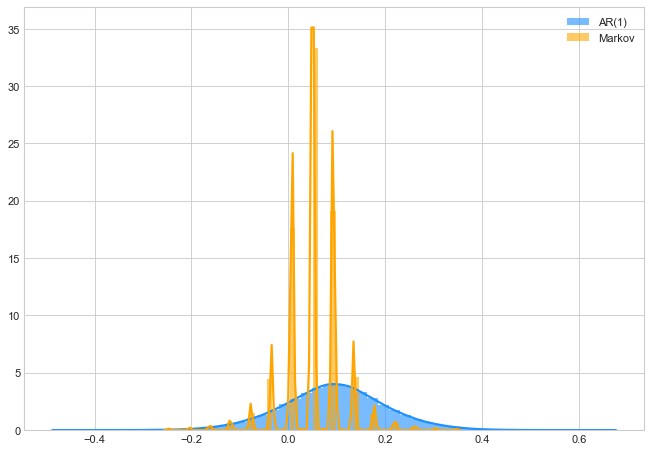

In [13]:
import seaborn as sns
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(AR1_y.flatten(), color="dodgerblue", label="AR(1)", **kwargs)
sns.distplot(Markov_y.flatten(), color="orange", label="Markov", **kwargs)
# plt.xlim(50,75)
plt.legend()
plt.show() 

## Moments

In [16]:
from scipy.stats import kurtosis, tstd, skew

In [17]:
AR1_y_flat = AR1_y.flatten()
Markov_y_flat = Markov_y.flatten()
mean_AR1, mean_markov = np.average(AR1_y_flat), np.average(Markov_y_flat)
std_AR1, std_markov = tstd(AR1_y_flat), tstd(Markov_y_flat)
skew_AR1, skew_markov = skew(AR1_y_flat), skew(Markov_y_flat)
kurtosis_AR1, kurtosis_markov = kurtosis(AR1_y_flat), kurtosis(Markov_y_flat)



In [18]:
print(mean_AR1, mean_markov) 
print(std_AR1, std_markov) 
print(skew_AR1, skew_markov) 
print(kurtosis_AR1, kurtosis_markov) 


0.09364294883058456 0.05037117699550096
0.10680209086423093 0.05643053054472135
-0.017986607015817578 -0.12427086270806371
0.27695863199041293 3.6487930482244053
